In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from ebc.sequential.non_iterative import SensitivityBasedIS
from ebc.sequential.iterative_with_convexification import SensitivityBasedFW
from ebc.sequential.iterative_no_convexification import SparseVI, GIGA, IHT
from ebc.gaussian import fisher_norm_under_true_gaussian_posterior, gaussian_multivariate_log_likelihood, gaussian_KL

In [2]:
from sklearn.decomposition import PCA

def plot_points(points, indices, w):
    pca = PCA(n_components = 2)
    vecs = pca.fit_transform(points)
    plt.scatter(vecs[indices, 0], vecs[indices, 1], 
                  s = w.flatten()[indices] * 50, alpha = 0.5)
    vecs = np.delete(vecs, indices, axis = 0)
    plt.scatter(vecs[:, 0], vecs[:, 1], alpha = 0.5, label = "NOT in coreset")
    plt.title("Points")
    plt.ylabel("PCA2")
    plt.xlabel("PCA1")
    plt.grid()
    plt.legend()
    
def plot_results(fkl, bkl, points, indices, w):
    fig, ax = plt.subplots(1, 3, figsize = (20, 5))
    ax[0].plot(fkl)
    ax[0].set_title("FKL")
    ax[0].set_ylabel("FKL")
    ax[0].set_xlabel("Coreset Size")
    ax[0].grid()
    
    ax[1].plot(fkl)
    ax[1].set_title("BKL")
    ax[1].set_ylabel("BKL")
    ax[1].set_xlabel("Coreset Size")
    ax[1].grid()
    
    pca = PCA(n_components = 2)
    vecs = pca.fit_transform(points)
    ax[2].scatter(vecs[indices, 0], vecs[indices, 1], 
                  s = w.flatten()[indices] * 50, alpha = 0.5)
    vecs = np.delete(vecs, indices, axis = 0)
    ax[2].scatter(vecs[:, 0], vecs[:, 1], alpha = 0.5, label = "NOT in coreset")
    ax[2].set_title("Points")
    ax[2].set_ylabel("PCA2")
    ax[2].set_xlabel("PCA1")
    ax[2].grid()
    ax[2].legend()
    
    #for ind in indices:
    #    ax[2].annotate(round(w.flatten()[ind]), (vecs[ind, 0], vecs[ind, 1]))

## 1. Multivariate Gaussian's Mean

In [15]:
def log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return np.diag(gaussian_multivariate_log_likelihood(X.T, mu, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [16]:
seeds = [123, 1234, 12345, 123456, 1234567]

fkls = []
bkls = []

for seed in seeds:

    # Generate Data
    d = 20
    N = 600

    np.random.seed(seed)

    # Theta as in sparse_vi
    theta = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d))

    # x as in sparse_vi
    x = np.random.multivariate_normal(mean = theta, cov = np.identity(d), size = N)

    # Parameters
    sigma_0 = np.identity(d)
    sigma = np.identity(d)
    mu_0 = np.zeros(d).reshape(-1, 1)

    # Full Gaussian posterior
    sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
    mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x, axis = 0).reshape(-1, 1))        

    from ebc.approximations import random_kitchen_sinks
    v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                         np.ones(2 * d), 1000, norm = "2", MCMC_subs_size = 500)
    
    likelihood_gram_matrix = v @ v.T
    
    fkl = np.zeros((10, 5))
    bkl = np.zeros((10, 5))

    na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.ones(2 * d),
          "S": 500,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "MCMC",
          "MCMC_subs_size": 500,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.ones(2 * d)}
    j = 0
    for i in range(1, 100, 10):
        sbis = SensitivityBasedIS(x)
        sbfw = SensitivityBasedFW(x)
        giga = GIGA(x)
        svi = SparseVI(x)
        iht = IHT(x)
        w1, I1 = sbis.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
        w2, I2 = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
        w3, I3 = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
        w4, I4 = svi.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, 
                         norm_attributes = na, T = 400, gamma_func = lambda x : 1e-4 / x)
        w5, I5 = iht.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)

        # Calculate posterior approximation
        sigma_hat = 1 / (1 + np.sum(w1)) * np.identity(d)
        mu_hat = sigma_hat @ (mu_0 + x.T @ w1)

        fkl[j, 0] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
        bkl[j, 0] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)

        # Calculate posterior approximation
        sigma_hat = 1 / (1 + np.sum(w2)) * np.identity(d)
        mu_hat = sigma_hat @ (mu_0 + x.T @ w2)

        fkl[j, 1] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
        bkl[j, 1] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)

        # Calculate posterior approximation
        sigma_hat = 1 / (1 + np.sum(w3)) * np.identity(d)
        mu_hat = sigma_hat @ (mu_0 + x.T @ w3)

        fkl[j, 2] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
        bkl[j, 2] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)

        # Calculate posterior approximation
        sigma_hat = 1 / (1 + np.sum(w4)) * np.identity(d)
        mu_hat = sigma_hat @ (mu_0 + x.T @ w4)

        fkl[j, 3] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
        bkl[j, 3] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)

        # Calculate posterior approximation
        sigma_hat = 1 / (1 + np.sum(w5)) * np.identity(d)
        mu_hat = sigma_hat @ (mu_0 + x.T @ w5)

        fkl[j, 4] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
        bkl[j, 4] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)

        j += 1
        
    fkls.append(fkl)
    bkls.append(bkl)

In [17]:
fmeds = np.zeros((10, 5))
fstds = np.zeros((10, 5))

for k in range(5):
    for j in range(10):
        agr = []
        
        for i in range(5):
            agr.append(fkls[i][j][k])
        fmeds[j, k] = np.median(agr)
        fstds[j, k] = np.std(agr)

In [18]:
bmeds = np.zeros((10, 5))
bstds = np.zeros((10, 5))

for k in range(5):
    for j in range(10):
        agr = []
        for i in range(5):
            agr.append(bkls[i][j][k])
        bmeds[j, k] = np.median(agr)
        bstds[j, k] = np.std(agr)

In [19]:
coreset_size = np.arange(1, 100, 10)

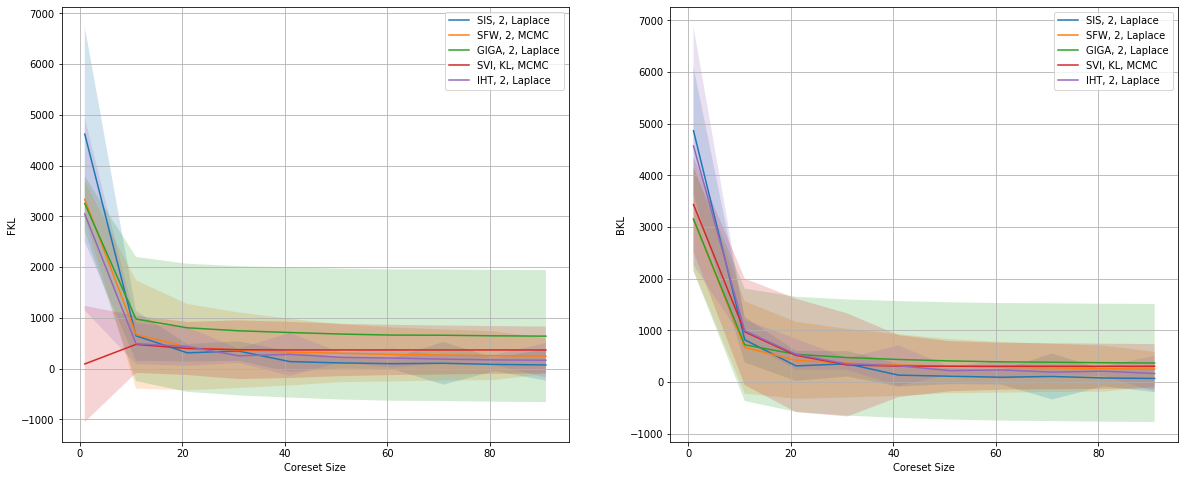

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(coreset_size, fmeds[:, 0], label = 'SIS, 2, Laplace')
ax[0].plot(coreset_size, fmeds[:, 1], label = 'SFW, 2, MCMC')
ax[0].plot(coreset_size, fmeds[:, 2], label = 'GIGA, 2, Laplace')
ax[0].plot(coreset_size, fmeds[:, 3], label = 'SVI, KL, MCMC')
ax[0].plot(coreset_size, fmeds[:, 4], label = 'IHT, 2, Laplace')
ax[0].fill_between(coreset_size, fmeds[:, 0] - fstds[:, 0], fmeds[:, 0] + fstds[:, 0], alpha=0.2)
ax[0].fill_between(coreset_size, fmeds[:, 1] - fstds[:, 1], fmeds[:, 1] + fstds[:, 1], alpha=0.2)
ax[0].fill_between(coreset_size, fmeds[:, 2] - fstds[:, 2], fmeds[:, 2] + fstds[:, 2], alpha=0.2)
ax[0].fill_between(coreset_size, fmeds[:, 3] - fstds[:, 3], fmeds[:, 3] + fstds[:, 3], alpha=0.2)
ax[0].fill_between(coreset_size, fmeds[:, 4] - fstds[:, 4], fmeds[:, 4] + fstds[:, 4], alpha=0.2)
ax[0].legend()
ax[0].set_xlabel("Coreset Size")
ax[0].set_ylabel("FKL")
ax[0].grid()

ax[1].plot(coreset_size, bmeds[:, 0], label = 'SIS, 2, Laplace')
ax[1].plot(coreset_size, bmeds[:, 1], label = 'SFW, 2, Laplace')
ax[1].plot(coreset_size, bmeds[:, 2], label = 'GIGA, 2, Laplace')
ax[1].plot(coreset_size, bmeds[:, 3], label = 'SVI, KL, MCMC')
ax[1].plot(coreset_size, bmeds[:, 4], label = 'IHT, 2, Laplace')
ax[1].fill_between(coreset_size, bmeds[:, 0] - bstds[:, 0], bmeds[:, 0] + bstds[:, 0], alpha=0.2)
ax[1].fill_between(coreset_size, bmeds[:, 1] - bstds[:, 1], bmeds[:, 1] + bstds[:, 1], alpha=0.2)
ax[1].fill_between(coreset_size, bmeds[:, 2] - bstds[:, 2], bmeds[:, 2] + bstds[:, 2], alpha=0.2)
ax[1].fill_between(coreset_size, bmeds[:, 3] - bstds[:, 3], bmeds[:, 3] + bstds[:, 3], alpha=0.2)
ax[1].fill_between(coreset_size, bmeds[:, 4] - bstds[:, 4], bmeds[:, 4] + bstds[:, 4], alpha=0.2)
ax[1].legend()
ax[1].set_xlabel("Coreset Size")
ax[1].set_ylabel("BKL")
ax[1].grid()

## 2. Multivariate Gaussian Mixture Means

In [262]:
def log_likelihood(params, X, y, weights):
    pi1 = params[0]
    mu1 = params[1:(d+1)].reshape(-1, 1)
    sigma1 = np.diag(params[d+1:2*d+1].reshape(-1, 1)[:, 0] + 1e-10)
    mu2 = params[2*d+1:3*d+1].reshape(-1, 1)
    sigma2 = np.diag(params[3*d+1:].reshape(-1, 1)[:, 0] + 1e-10)
    
    return pi1 * np.diag(gaussian_multivariate_log_likelihood(X.T, mu1, sigma1)).reshape(-1, 1) +\
            (1-pi1) * np.diag(gaussian_multivariate_log_likelihood(X.T, mu2, sigma2)).reshape(-1, 1)

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [263]:
import pandas as pd

def gm_posterior_approx(w, indices, x1, x2, mu_0):
    dum = pd.DataFrame({'ind': indices.flatten().tolist(), 'w': w.flatten().tolist()})
    dum = dum.sort_values(by = 'ind')
    w1 = np.array(dum.w[:int(len(w) // 2)]).reshape(-1, 1)
    w2 = np.array(dum.w[int(len(w) // 2):]).reshape(-1, 1)
    
    sigma_hat_1 = 1 / (1 + np.sum(w1)) * np.identity(d)
    mu_hat_1 = sigma_hat_1 @ (mu_0 + x1.T @ w1)
    sigma_hat_2 = 1 / (1 + np.sum(w2)) * np.identity(d)
    mu_hat_2 = sigma_hat_2 @ (mu_0 + x2.T @ w2)
    
    return sigma_hat_1, mu_hat_1, sigma_hat_2, mu_hat_2

In [264]:
from ebc.gaussian import gaussian_multivariate_log_likelihood

def KL_estimate_gm(sigma_full_1, mu_full_1, sigma_full_2, mu_full_2, sigma_hat_1, mu_hat_1, sigma_hat_2, mu_hat_2):
    x = np.random.uniform(0, 1, (10000, 20))
    
    params_full = [1/2] + mu_full_1.flatten().tolist() + np.diag(sigma_full_1).flatten().tolist() +\
    mu_full_2.flatten().tolist() + np.diag(sigma_full_2).flatten().tolist()
    params_full = np.array(params_full)
    
    params_hat = [1/2] + mu_hat_1.flatten().tolist() + np.diag(sigma_hat_1).flatten().tolist() +\
    mu_hat_2.flatten().tolist() + np.diag(sigma_hat_2).flatten().tolist()
    params_hat = np.array(params_hat)
    
    f = log_likelihood(params_full, x, None, 1)
    g = log_likelihood(params_hat, x, None, 1)
    g[g == 0] = 1e-10
    
    fkl = np.mean(f * (f - g))
    bkl = np.mean(g * (g - f))
    
    return fkl, bkl

In [265]:
seeds = [123, 1234, 12345, 123456, 1234567]

fkls = []
bkls = []

for seed in seeds:

    # Generate Data
    d = 20
    N = 600

    np.random.seed(seed)

    # Mean value
    theta1 = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d)) # mean = 0
    theta2 = np.random.multivariate_normal(mean = np.ones(d) * 4, cov = np.identity(d)) # mean = 4

    # X_{n x d}
    x1 = np.random.multivariate_normal(mean = theta1, cov = np.identity(d), size = int(N // 2))
    x2 = np.random.multivariate_normal(mean = theta2, cov = np.identity(d), size = int(N // 2))
    x = np.vstack([x1, x2])
    random_inds = np.random.choice(np.arange(len(x)), len(x), False)
    x = x[random_inds]

    # Parameters
    sigma_0 = np.identity(d)
    sigma = np.identity(d)
    mu_0 = np.zeros(d).reshape(-1, 1)

    # Full Gaussian posterior
    sigma_full_1 = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
    mu_full_1 =  sigma_full_1 @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x1, axis = 0).reshape(-1, 1))
    sigma_full_2 = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
    mu_full_2 =  sigma_full_2 @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x2, axis = 0).reshape(-1, 1))

    from ebc.approximations import random_kitchen_sinks
    v = random_kitchen_sinks(x, None, 1, "MCMC", log_likelihood, 
                         np.ones(4 * d + 1), 1000, norm = "2", MCMC_subs_size = 500)
    
    likelihood_gram_matrix = v @ v.T
    
    fkl = np.zeros((10, 5))
    bkl = np.zeros((10, 5))

    na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.ones(4 * d + 1),
          "S": 500,
          "log_likelihood_gradient": None,
          "approx": "MCMC",
          "MCMC_subs_size": 500,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.ones(4 * d + 1)}
    
    j = 0
    for i in range(1, 100, 10):
        print(i)
        sbis = SensitivityBasedIS(x)
        sbfw = SensitivityBasedFW(x)
        giga = GIGA(x)
        svi = SparseVI(x)
        iht = IHT(x)

        w1, I1 = sbis.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
        w2, I2 = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
        w3, I3 = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
        w4, I4 = svi.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, 
                         norm_attributes = na, T = 100, gamma_func = lambda x : 0.1 / x)
        w5, I5 = iht.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)

        # Calculate posterior approximation
        sigma_hat_1, mu_hat_1, sigma_hat_2, mu_hat_2 = gm_posterior_approx(w1, random_inds, x1, x2, mu_0)
        fkln, bkln = KL_estimate_gm(sigma_full_1, mu_full_1, sigma_full_2, mu_full_2,
                                  sigma_hat_1, mu_hat_1, sigma_hat_2, mu_hat_2)

        fkl[j, 0] = fkln
        bkl[j, 0] = bkln
        
        # Calculate posterior approximation
        sigma_hat_1, mu_hat_1, sigma_hat_2, mu_hat_2 = gm_posterior_approx(w2, random_inds, x1, x2, mu_0)
        fkln, bkln = KL_estimate_gm(sigma_full_1, mu_full_1, sigma_full_2, mu_full_2,
                                  sigma_hat_1, mu_hat_1, sigma_hat_2, mu_hat_2)
        
        fkl[j, 1] = fkln
        bkl[j, 1] = bkln

        # Calculate posterior approximation
        sigma_hat_1, mu_hat_1, sigma_hat_2, mu_hat_2 = gm_posterior_approx(w3, random_inds, x1, x2, mu_0)
        fkln, bkln = KL_estimate_gm(sigma_full_1, mu_full_1, sigma_full_2, mu_full_2,
                                  sigma_hat_1, mu_hat_1, sigma_hat_2, mu_hat_2)

        fkl[j, 2] = fkln
        bkl[j, 2] = bkln

        # Calculate posterior approximation
        sigma_hat_1, mu_hat_1, sigma_hat_2, mu_hat_2 = gm_posterior_approx(w4, random_inds, x1, x2, mu_0)
        fkln, bkln = KL_estimate_gm(sigma_full_1, mu_full_1, sigma_full_2, mu_full_2,
                                  sigma_hat_1, mu_hat_1, sigma_hat_2, mu_hat_2)

        fkl[j, 3] = fkln
        bkl[j, 3] = bkln

        # Calculate posterior approximation
        sigma_hat_1, mu_hat_1, sigma_hat_2, mu_hat_2 = gm_posterior_approx(w5, random_inds, x1, x2, mu_0)
        fkln, bkln = KL_estimate_gm(sigma_full_1, mu_full_1, sigma_full_2, mu_full_2,
                                  sigma_hat_1, mu_hat_1, sigma_hat_2, mu_hat_2)

        fkl[j, 4] = fkln
        bkl[j, 4] = bkln

        j += 1
        
    fkls.append(fkl)
    bkls.append(bkl)

1
11
21
31
41
51
61
71
81
91
1
11
21
31
41
51
61
71
81
91
1
11
21
31
41
51
61
71
81
91
1
11
21
31
41
51
61
71
81
91
1
11
21
31
41
51
61
71
81
91


In [266]:
fmeds = np.zeros((10, 5))
fstds = np.zeros((10, 5))

for k in range(5):
    for j in range(10):
        agr = []
        for i in range(2):
            agr.append(fkls[i][j][k])
        fmeds[j, k] = np.median(agr)
        fstds[j, k] = np.std(agr)
        
bmeds = np.zeros((10, 5))
bstds = np.zeros((10, 5))

for k in range(5):
    for j in range(10):
        agr = []
        for i in range(2):
            agr.append(bkls[i][j][k])
        bmeds[j, k] = np.median(agr)
        bstds[j, k] = np.std(agr)
        
coreset_size = np.arange(1, 100, 10)

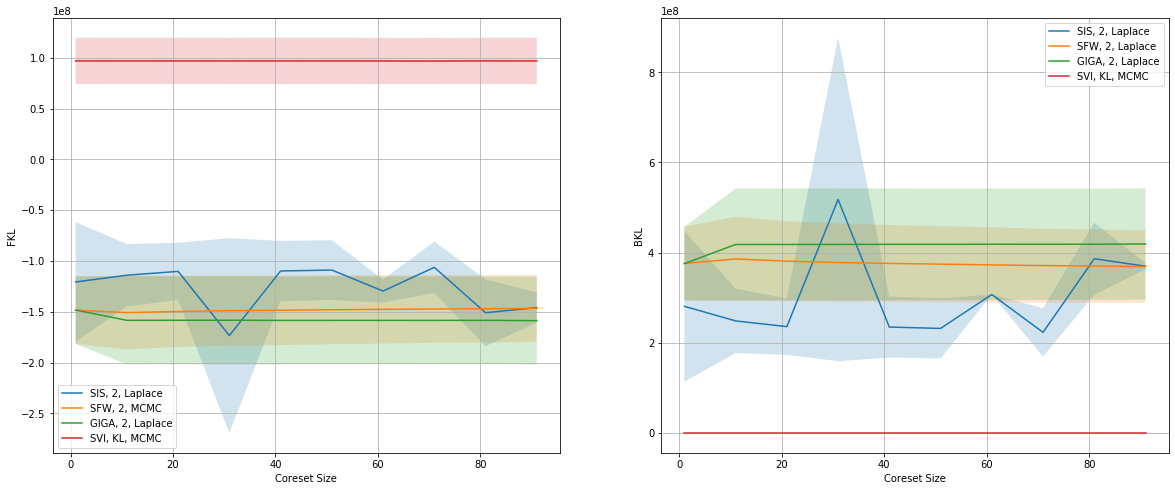

In [270]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(coreset_size, fmeds[:, 0], label = 'SIS, 2, Laplace')
ax[0].plot(coreset_size, fmeds[:, 1], label = 'SFW, 2, MCMC')
ax[0].plot(coreset_size, fmeds[:, 2], label = 'GIGA, 2, Laplace')
ax[0].plot(coreset_size, fmeds[:, 3], label = 'SVI, KL, MCMC')
#ax[0].plot(coreset_size, fmeds[:, 4], label = 'IHT, 2, Laplace')
ax[0].fill_between(coreset_size, fmeds[:, 0] - fstds[:, 0], fmeds[:, 0] + fstds[:, 0], alpha=0.2)
ax[0].fill_between(coreset_size, fmeds[:, 1] - fstds[:, 1], fmeds[:, 1] + fstds[:, 1], alpha=0.2)
ax[0].fill_between(coreset_size, fmeds[:, 2] - fstds[:, 2], fmeds[:, 2] + fstds[:, 2], alpha=0.2)
ax[0].fill_between(coreset_size, fmeds[:, 3] - fstds[:, 3], fmeds[:, 3] + fstds[:, 3], alpha=0.2)
#ax[0].fill_between(coreset_size, fmeds[:, 4] - fstds[:, 4], fmeds[:, 4] + fstds[:, 4], alpha=0.2)
ax[0].legend()
ax[0].set_xlabel("Coreset Size")
ax[0].set_ylabel("FKL")
ax[0].grid()

ax[1].plot(coreset_size, bmeds[:, 0], label = 'SIS, 2, Laplace')
ax[1].plot(coreset_size, bmeds[:, 1], label = 'SFW, 2, Laplace')
ax[1].plot(coreset_size, bmeds[:, 2], label = 'GIGA, 2, Laplace')
ax[1].plot(coreset_size, bmeds[:, 3], label = 'SVI, KL, MCMC')
#ax[1].plot(coreset_size, bmeds[:, 4], label = 'IHT, 2, Laplace')
ax[1].fill_between(coreset_size, bmeds[:, 0] - bstds[:, 0], bmeds[:, 0] + bstds[:, 0], alpha=0.2)
ax[1].fill_between(coreset_size, bmeds[:, 1] - bstds[:, 1], bmeds[:, 1] + bstds[:, 1], alpha=0.2)
ax[1].fill_between(coreset_size, bmeds[:, 2] - bstds[:, 2], bmeds[:, 2] + bstds[:, 2], alpha=0.2)
ax[1].fill_between(coreset_size, bmeds[:, 3] - bstds[:, 3], bmeds[:, 3] + bstds[:, 3], alpha=0.2)
#ax[1].fill_between(coreset_size, bmeds[:, 4] - bstds[:, 4], bmeds[:, 4] + bstds[:, 4], alpha=0.2)
ax[1].legend()
ax[1].set_xlabel("Coreset Size")
ax[1].set_ylabel("BKL")
ax[1].grid()

## 3. Gaussian Regression

In [36]:
def log_likelihood(params, X, y, weights):
    N, d = X.shape
    beta = params.reshape(-1, 1)
    sigma = np.identity(N)
    
    return np.diag(gaussian_multivariate_log_likelihood(y, X @ beta, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    N, d = X.shape
    sigma = 1e-4 * np.identity(N)
    beta = params.reshape(-1, 1)
    
    return (-np.linalg.inv(sigma) @ (y - X @ beta)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [37]:
seeds = [123, 1234, 12345, 123456, 1234567]

fkls = []
bkls = []

for seed in seeds:
    # Generate Data
    d = 20
    N = 600

    np.random.seed(seed)

    # x as in sparse_vi
    cov = np.identity(d) * 3
    cov[cov == 0] = 1
    x = np.random.multivariate_normal(mean = np.zeros(d), cov = cov, size = N)

    # as in svi
    mu_0 = np.zeros(d).reshape(-1, 1)
    sigma_0 = np.identity(d)
    #beta = np.random.multivariate_normal(mu_0.flatten(), sigma_0).reshape(-1, 1)
    beta = np.random.randint(3, 10, size = d).reshape(-1, 1)

    # y
    sigma = 1
    y = x @ beta + np.random.normal(0, sigma, (N, 1))

    # Full  posterior
    sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + 1 / sigma ** 2 * x.T @ x)
    mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + 1 / sigma ** 2 * np.sum(y * x, axis = 0).reshape(-1, 1))        

    from ebc.approximations import random_kitchen_sinks
    v = random_kitchen_sinks(x, y, 1, "Laplace", log_likelihood, 
                         np.ones(d), 1000, norm = "2", MCMC_subs_size = 500)

    likelihood_gram_matrix = v @ v.T

    fkl = np.zeros((10, 5))
    bkl = np.zeros((10, 5))

    na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.ones(d),
          "S": 500,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "MCMC",
          "MCMC_subs_size": 500,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.ones(d)}
    j = 0
    for i in range(1, 100, 10):
        print(i)
        sbis = SensitivityBasedIS(x, y)
        sbfw = SensitivityBasedFW(x, y)
        giga = GIGA(x, y)
        svi = SparseVI(x, y)
        iht = IHT(x, y)

        w1, I1 = sbis.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
        w2, I2 = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
        w3, I3 = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
        w4, I4 = svi.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, 
                         norm_attributes = na, T = 400, gamma_func = lambda x : 0.01 / x)
        w5, I5 = iht.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)

        # Calculate posterior approximation
        sigma_hat = np.linalg.inv(np.linalg.inv(sigma_0) + 1 / sigma ** 2 * x.T @ (x * w1))
        mu_hat =  sigma_hat @ (np.linalg.inv(sigma_0) @ mu_0 + 1 / (sigma ** 2) * np.sum(w1 * y * x, axis = 0).reshape(-1, 1))        

        fkl[j, 0] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
        bkl[j, 0] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)

        # Calculate posterior approximation
        sigma_hat = np.linalg.inv(np.linalg.inv(sigma_0) + 1 / sigma ** 2 * x.T @ (x * w2))
        mu_hat =  sigma_hat @ (np.linalg.inv(sigma_0) @ mu_0 + 1 / (sigma ** 2) * np.sum(w2 * y * x, axis = 0).reshape(-1, 1))        

        fkl[j, 1] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
        bkl[j, 1] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)

        # Calculate posterior approximation
        sigma_hat = np.linalg.inv(np.linalg.inv(sigma_0) + 1 / sigma ** 2 * x.T @ (x * w3))
        mu_hat =  sigma_hat @ (np.linalg.inv(sigma_0) @ mu_0 + 1 / (sigma ** 2) * np.sum(w3 * y * x, axis = 0).reshape(-1, 1))        

        fkl[j, 2] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
        bkl[j, 2] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)

        # Calculate posterior approximation
        sigma_hat = np.linalg.inv(np.linalg.inv(sigma_0) + 1 / sigma ** 2 * x.T @ (x * w4))
        mu_hat =  sigma_hat @ (np.linalg.inv(sigma_0) @ mu_0 + 1 / (sigma ** 2) * np.sum(w4 * y * x, axis = 0).reshape(-1, 1))        

        fkl[j, 3] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
        bkl[j, 3] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)

        # Calculate posterior approximation
        sigma_hat = np.linalg.inv(np.linalg.inv(sigma_0) + 1 / sigma ** 2 * x.T @ (x * w5))
        mu_hat =  sigma_hat @ (np.linalg.inv(sigma_0) @ mu_0 + 1 / (sigma ** 2) * np.sum(w5 * y * x, axis = 0).reshape(-1, 1))        

        fkl[j, 4] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
        bkl[j, 4] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)

        j += 1

    fkls.append(fkl)
    bkls.append(bkl)

1
11
21
31
41
51
61
71
81
91
1
11


/Users/vladimiromelyusik/efficient_bayesian_coresets/ebc/sequential/iterative_no_convexification.py:197: RuntimeWarning: invalid value encountered in double_scalars
  gamma = numerator / denominator
/opt/anaconda3/lib/python3.8/site-packages/numpy/linalg/linalg.py:2057: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


21
31
41
51
61
71
81
91
1
11


/Users/vladimiromelyusik/efficient_bayesian_coresets/ebc/sequential/iterative_no_convexification.py:197: RuntimeWarning: invalid value encountered in double_scalars
  gamma = numerator / denominator
/opt/anaconda3/lib/python3.8/site-packages/numpy/linalg/linalg.py:2057: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


21
31
41
51
61
71
81
91
1
11


/Users/vladimiromelyusik/efficient_bayesian_coresets/ebc/sequential/iterative_no_convexification.py:197: RuntimeWarning: invalid value encountered in double_scalars
  gamma = numerator / denominator
/opt/anaconda3/lib/python3.8/site-packages/numpy/linalg/linalg.py:2057: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


21
31
41
51
61
71
81
91
1
11


/Users/vladimiromelyusik/efficient_bayesian_coresets/ebc/sequential/iterative_no_convexification.py:197: RuntimeWarning: invalid value encountered in double_scalars
  gamma = numerator / denominator
/opt/anaconda3/lib/python3.8/site-packages/numpy/linalg/linalg.py:2057: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


21
31
41
51
61
71
81
91


In [38]:
fmeds = np.zeros((10, 5))
fstds = np.zeros((10, 5))

for k in range(5):
    for j in range(10):
        agr = []
        for i in range(2):
            agr.append(fkls[i][j][k])
        fmeds[j, k] = np.median(agr)
        fstds[j, k] = np.std(agr)
        
bmeds = np.zeros((10, 5))
bstds = np.zeros((10, 5))

for k in range(5):
    for j in range(10):
        agr = []
        for i in range(2):
            agr.append(bkls[i][j][k])
        bmeds[j, k] = np.median(agr)
        bstds[j, k] = np.std(agr)
        
coreset_size = np.arange(1, 100, 10)

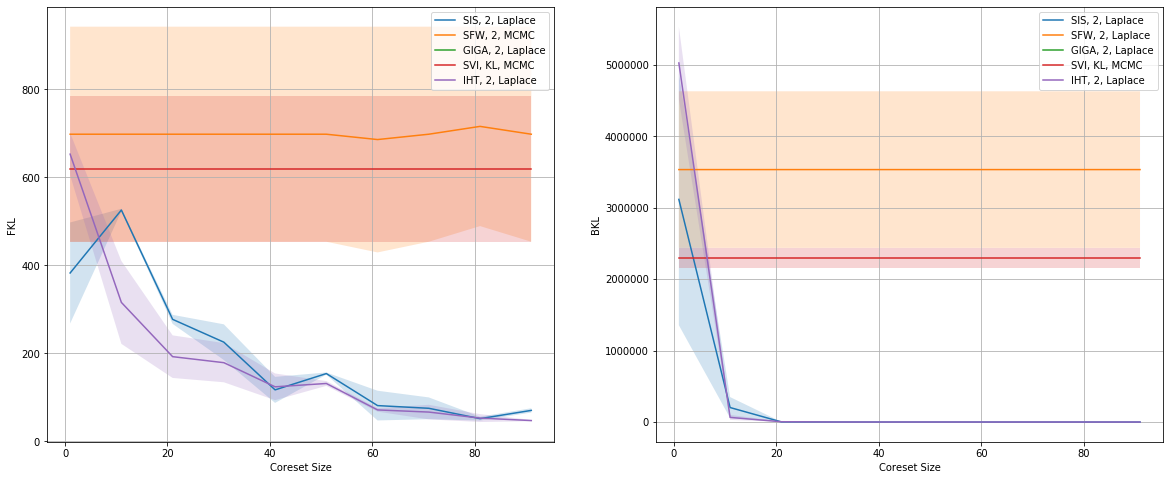

In [39]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(coreset_size, fmeds[:, 0], label = 'SIS, 2, Laplace')
ax[0].plot(coreset_size, fmeds[:, 1], label = 'SFW, 2, MCMC')
ax[0].plot(coreset_size, fmeds[:, 2], label = 'GIGA, 2, Laplace')
ax[0].plot(coreset_size, fmeds[:, 3], label = 'SVI, KL, MCMC')
ax[0].plot(coreset_size, fmeds[:, 4], label = 'IHT, 2, Laplace')
ax[0].fill_between(coreset_size, fmeds[:, 0] - fstds[:, 0], fmeds[:, 0] + fstds[:, 0], alpha=0.2)
ax[0].fill_between(coreset_size, fmeds[:, 1] - fstds[:, 1], fmeds[:, 1] + fstds[:, 1], alpha=0.2)
ax[0].fill_between(coreset_size, fmeds[:, 2] - fstds[:, 2], fmeds[:, 2] + fstds[:, 2], alpha=0.2)
ax[0].fill_between(coreset_size, fmeds[:, 3] - fstds[:, 3], fmeds[:, 3] + fstds[:, 3], alpha=0.2)
ax[0].fill_between(coreset_size, fmeds[:, 4] - fstds[:, 4], fmeds[:, 4] + fstds[:, 4], alpha=0.2)
ax[0].legend()
ax[0].set_xlabel("Coreset Size")
ax[0].set_ylabel("FKL")
ax[0].grid()

ax[1].plot(coreset_size, bmeds[:, 0], label = 'SIS, 2, Laplace')
ax[1].plot(coreset_size, bmeds[:, 1], label = 'SFW, 2, Laplace')
ax[1].plot(coreset_size, bmeds[:, 2], label = 'GIGA, 2, Laplace')
ax[1].plot(coreset_size, bmeds[:, 3], label = 'SVI, KL, MCMC')
ax[1].plot(coreset_size, bmeds[:, 4], label = 'IHT, 2, Laplace')
ax[1].fill_between(coreset_size, bmeds[:, 0] - bstds[:, 0], bmeds[:, 0] + bstds[:, 0], alpha=0.2)
ax[1].fill_between(coreset_size, bmeds[:, 1] - bstds[:, 1], bmeds[:, 1] + bstds[:, 1], alpha=0.2)
ax[1].fill_between(coreset_size, bmeds[:, 2] - bstds[:, 2], bmeds[:, 2] + bstds[:, 2], alpha=0.2)
ax[1].fill_between(coreset_size, bmeds[:, 3] - bstds[:, 3], bmeds[:, 3] + bstds[:, 3], alpha=0.2)
ax[1].fill_between(coreset_size, bmeds[:, 4] - bstds[:, 4], bmeds[:, 4] + bstds[:, 4], alpha=0.2)
ax[1].legend()
ax[1].set_xlabel("Coreset Size")
ax[1].set_ylabel("BKL")
ax[1].grid()

In [41]:
bmeds

array([[3.11634825e+06, 3.53354538e+06, 3.53354538e+06, 2.29667809e+06,
        5.02597969e+06],
       [2.02914302e+05, 3.53354538e+06,            nan, 2.29667809e+06,
        6.48900712e+04],
       [2.11916637e+03, 3.53354538e+06,            nan, 2.29667809e+06,
        4.24061173e+03],
       [6.50643170e+02, 3.53354538e+06,            nan, 2.29667809e+06,
        4.54148488e+02],
       [2.07441368e+02, 3.53354538e+06,            nan, 2.29667809e+06,
        2.31442445e+02],
       [3.01987715e+02, 3.53354538e+06,            nan, 2.29667809e+06,
        2.42484201e+02],
       [1.21228588e+02, 3.53354937e+06,            nan, 2.29667809e+06,
        1.18162028e+02],
       [9.42351247e+01, 3.53354538e+06,            nan, 2.29667809e+06,
        1.23354767e+02],
       [7.98583724e+01, 3.53354176e+06,            nan, 2.29667809e+06,
        8.48751325e+01],
       [9.40068725e+01, 3.53354538e+06,            nan, 2.29667809e+06,
        6.56362343e+01]])

## 4. Regression on Real Dataset

In [32]:
from sklearn.datasets import load_boston
X = load_boston()['data']
y = load_boston()['target']
y.shape

(506,)

In [21]:
def log_likelihood(params, X, y, weights):
    N, d = X.shape
    beta = params.reshape(-1, 1)
    sigma = np.identity(N)
    
    return np.diag(gaussian_multivariate_log_likelihood(y, X @ beta, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    N, d = X.shape
    sigma = 1e-4 * np.identity(N)
    beta = params.reshape(-1, 1)
    
    return (-np.linalg.inv(sigma) @ (y - X @ beta)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [22]:
from sklearn.datasets import load_boston
X = load_boston()['data']
y = load_boston()['target']

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

lr = LinearRegression()
ref = lr.fit(X, y).predict(X)

In [25]:
seeds = [123, 1234, 12345, 123456, 1234567]

maes = []

for seed in seeds:
    # Generate Data
    N, d = X.shape

    np.random.seed(seed)     

    from ebc.approximations import random_kitchen_sinks
    v = random_kitchen_sinks(X, y, 1, "Laplace", log_likelihood, 
                         np.ones(d), 1000, norm = "2", MCMC_subs_size = 500)

    likelihood_gram_matrix = v @ v.T

    mae = np.zeros((10, 5))

    na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.ones(d),
          "S": 500,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "MCMC",
          "MCMC_subs_size": 500,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.ones(d)}
    j = 0
    for i in range(1, 100, 10):
        print(i)
        sbis = SensitivityBasedIS(X, y)
        sbfw = SensitivityBasedFW(X, y)
        giga = GIGA(X, y)
        svi = SparseVI(X, y)
        iht = IHT(X, y)

        w1, I1 = sbis.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
        w2, I2 = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
        w3, I3 = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
        w4, I4 = svi.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, 
                         norm_attributes = na, T = 400, gamma_func = lambda x : 0.01 / x)
        w5, I5 = iht.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
        
        lr = LinearRegression()
        pred1 = lr.fit(X * w1, y).predict(X)
        pred2 = lr.fit(X * w2, y).predict(X)
        pred3 = lr.fit(X * w3, y).predict(X)
        pred4 = lr.fit(X * w4, y).predict(X)
        pred5 = lr.fit(X * w5, y).predict(X)
        
        mae[j, 0] = mean_absolute_error(ref, pred1)
        mae[j, 1] = mean_absolute_error(ref, pred2)
        mae[j, 2] = mean_absolute_error(ref, pred3)
        mae[j, 3] = mean_absolute_error(ref, pred4)
        mae[j, 4] = mean_absolute_error(ref, pred5)

        j += 1
        
    maes.append(mae)

1
11
21
31
41
51
61
71
81
91
1
11
21
31
41
51
61
71
81
91
1
11
21
31
41
51
61
71
81
91
1
11
21
31
41
51
61
71
81
91
1
11
21
31
41
51
61
71
81
91


In [26]:
maemeds = np.zeros((10, 5))
maestds = np.zeros((10, 5))

for k in range(5):
    for j in range(10):
        agr = []
        for i in range(2):
            agr.append(maes[i][j][k])
        maemeds[j, k] = np.median(agr)
        maestds[j, k] = np.std(agr)

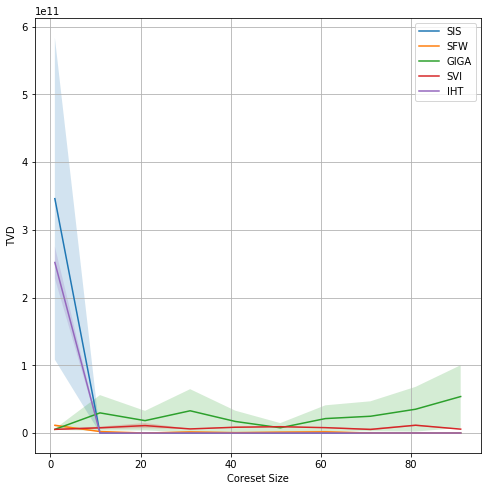

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(coreset_size, maemeds[:, 0], label = 'SIS')
ax.plot(coreset_size, maemeds[:, 1], label = 'SFW')
ax.plot(coreset_size, maemeds[:, 2], label = 'GIGA')
ax.plot(coreset_size, maemeds[:, 3], label = 'SVI')
ax.plot(coreset_size, maemeds[:, 4], label = 'IHT')
ax.fill_between(coreset_size, maemeds[:, 0] - maestds[:, 0], maemeds[:, 0] + maestds[:, 0], alpha=0.2)
ax.fill_between(coreset_size, maemeds[:, 1] - maestds[:, 1], maemeds[:, 1] + maestds[:, 1], alpha=0.2)
ax.fill_between(coreset_size, maemeds[:, 2] - maestds[:, 2], maemeds[:, 2] + maestds[:, 2], alpha=0.2)
ax.fill_between(coreset_size, maemeds[:, 3] - maestds[:, 3], maemeds[:, 3] + maestds[:, 3], alpha=0.2)
ax.fill_between(coreset_size, maemeds[:, 4] - maestds[:, 4], maemeds[:, 4] + maestds[:, 4], alpha=0.2)
ax.legend()
ax.set_xlabel("Coreset Size")
ax.set_ylabel("TVD")
ax.grid()

## 5. Images

In [35]:
from sklearn.datasets import load_digits
X = load_digits()['data']
y_labels = load_digits()['target']
y_labels.shape

(1797,)

In [33]:
def log_likelihood(params, X, y, weights):
    N, d = X.shape
    c = y.shape[1]
    w = params.reshape(d, c)
    preds = X @ w
    probs = np.exp(preds - np.max(preds, axis = 1, keepdims = True))
    probs = probs / np.sum(probs, axis = 1, keepdims = True)
    probs[probs == 0] = 1e-10
    ll = np.sum(y * np.log(probs), axis = 1)
    return ll.reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [34]:
# https://github.com/izmailovpavel/neurips_bdl_starter_kit/blob/main/metrics.py
import scipy

def total_variation_distance(reference: np.array, predictions: np.array):
    """Returns total variation distance."""
    return np.abs(predictions - reference).sum(axis=-1).mean() / 2.


def w2_distance(reference: np.array, predictions: np.array):
    """Returns W-2 distance """
    assert predictions.shape[0] == reference.shape[0], "wrong predictions shape"
    return -np.mean([scipy.stats.wasserstein_distance(pred, ref) for 
                   pred, ref in zip(predictions, reference)])

In [35]:
from sklearn.datasets import load_digits
X = load_digits()['data']
y_labels = load_digits()['target']

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
ref = lr.fit(X, y_labels).predict(X)

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y = lb.fit_transform(y_labels)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
seeds = [123, 1234, 12345, 123456, 1234567]

tvs = []
wass2s = []

for seed in seeds:

    np.random.seed(seed)
    
    tv = np.zeros((10, 5))
    wass2 = np.zeros((10, 5))

    na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.zeros(X.shape[1] * y.shape[1]).reshape(-1, 1),
          "S": 500,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "MCMC",
          "MCMC_subs_size": 1000,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.zeros(X.shape[1] * y.shape[1]).reshape(-1, 1)}
    
    
    from ebc.approximations import random_kitchen_sinks
    v = random_kitchen_sinks(X, y, 1, "Laplace", log_likelihood, 
                             np.ones(X.shape[1] * y.shape[1]).reshape(-1, 1), 
                             1000, norm = "2", MCMC_subs_size = 500)

    likelihood_gram_matrix = v @ v.T
    
    j = 0
    for i in range(1, 100, 10):
        
        sbis = SensitivityBasedIS(X, y)
        sbfw = SensitivityBasedFW(X, y)
        giga = GIGA(X, y)
        svi = SparseVI(X, y)
        iht = IHT(X, y)
        w1, I1 = sbis.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
        w2, I2 = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
        w3, I3 = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
        w4, I4 = svi.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, 
                         norm_attributes = na, T = 400, gamma_func = lambda x : 1e-4 / x)
        w5, I5 = iht.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
        
        lr = LogisticRegression()
        pred1 = lr.fit(X * w1, y_labels).predict(X)
        pred2 = lr.fit(X * w2, y_labels).predict(X)
        pred3 = lr.fit(X * w3, y_labels).predict(X)
        pred4 = lr.fit(X * w4, y_labels).predict(X)
        pred5 = lr.fit(X * w5, y_labels).predict(X)
        
        
        tv[j, 0] = total_variation_distance(ref, pred1)
        try:
            wass2[j, 0] = w2_distance(ref, pred1)
        except:
            wass2[j, 0] = np.nan
        
        tv[j, 1] = total_variation_distance(ref, pred2)
        try:
            wass2[j, 1] = w2_distance(ref, pred2)
        except:
            wass2[j, 1] = np.nan
        
        tv[j, 2] = total_variation_distance(ref, pred3)
        try:
            wass2[j, 2] = w2_distance(ref, pred3)
        except:
            wass2[j, 2] = np.nan
        
        tv[j, 3] = total_variation_distance(ref, pred4)
        try:
            wass2[j, 3] = w2_distance(ref, pred4)
        except:
            wass2[j, 3] = np.nan
        
        tv[j, 4] = total_variation_distance(ref, pred5)
        try:
            wass2[j, 4] = w2_distance(ref, pred5)
        except:
            wass2[j, 4] = np.nan

        j += 1
        
    tvs.append(tv)
    wass2s.append(wass2)

/Users/vladimiromelyusik/efficient_bayesian_coresets/ebc/approximations.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_approx, sigma_approx, S) # S x (#mu + #sigma)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [37]:
tvsmeds = np.zeros((10, 5))
tvsstds = np.zeros((10, 5))

for k in range(5):
    for j in range(10):
        agr = []
        
        for i in range(5):
            agr.append(tvs[i][j][k])
        tvsmeds[j, k] = np.median(agr)
        tvsstds[j, k] = np.std(agr)

In [39]:
coreset_size = np.arange(1, 100, 10)

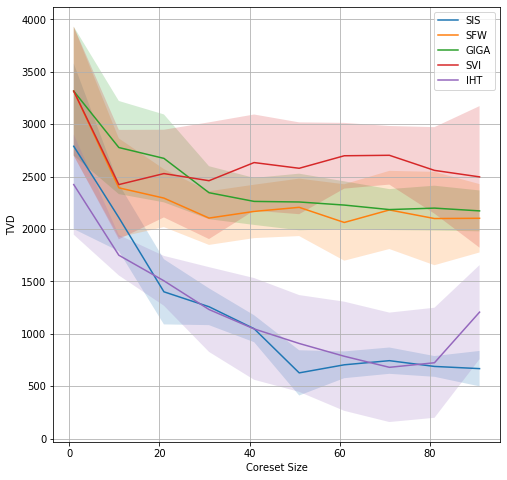

In [47]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(coreset_size, tvsmeds[:, 0], label = 'SIS')
ax.plot(coreset_size, tvsmeds[:, 1], label = 'SFW')
ax.plot(coreset_size, tvsmeds[:, 2], label = 'GIGA')
ax.plot(coreset_size, tvsmeds[:, 3], label = 'SVI')
ax.plot(coreset_size, tvsmeds[:, 4], label = 'IHT')
ax.fill_between(coreset_size, tvsmeds[:, 0] - tvsstds[:, 0], tvsmeds[:, 0] + tvsstds[:, 0], alpha=0.2)
ax.fill_between(coreset_size, tvsmeds[:, 1] - tvsstds[:, 1], tvsmeds[:, 1] + tvsstds[:, 1], alpha=0.2)
ax.fill_between(coreset_size, tvsmeds[:, 2] - tvsstds[:, 2], tvsmeds[:, 2] + tvsstds[:, 2], alpha=0.2)
ax.fill_between(coreset_size, tvsmeds[:, 3] - tvsstds[:, 3], tvsmeds[:, 3] + tvsstds[:, 3], alpha=0.2)
ax.fill_between(coreset_size, tvsmeds[:, 4] - tvsstds[:, 4], tvsmeds[:, 4] + tvsstds[:, 4], alpha=0.2)
ax.legend()
ax.set_xlabel("Coreset Size")
ax.set_ylabel("TVD")
ax.grid()